# Load Data (already cleaned)

In [1]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# read data in memory
train = pd.read_csv("C:\\Users\\Leo\\TaxiData\\clean_v2.csv",index_col=0)

E:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
test = pd.read_csv("C:\\Users\\Leo\\Dropbox\\Info Göttingen\\Practical Course Data Science\\Task 2\\data\\test_data_v2.csv",engine="python")

In [4]:
train.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,...,subtotal,tip_perc,pickup_hour,pickup_coord,dropoff_coord,avg_speed,holiday,overnight,day,ridesAtPickupHour
0,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,-73.977463,40.753979,2,...,7.3,0.000000,21,"(40.76093673706055, -73.98336029052734)","(40.75397872924805, -73.97746276855469)",7.255102,False,True,Thursday,20311.8
1,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,-73.981636,40.670242,1,...,23.3,0.171674,21,"(40.73666763305664, -73.98171997070312)","(40.67024230957031, -73.98163604736328)",10.957434,False,True,Thursday,20311.8
3,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,-73.929466,40.851540,1,...,27.3,0.036630,21,"(40.77389144897461, -73.98236083984375)","(40.851539611816406, -73.9294662475586)",14.996618,False,True,Thursday,20311.8
4,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,-73.985909,40.766445,1,...,14.8,0.200000,21,"(40.73317337036133, -73.98710632324219)","(40.7664451599121, -73.98590850830078)",11.082423,False,True,Thursday,20311.8
5,2016-06-09 21:06:36,2016-06-09 21:19:21,1,2.17,-73.995201,40.739491,1,-73.993202,40.762642,1,...,11.8,0.200000,21,"(40.7394905090332, -73.99520111083984)","(40.76264190673828, -73.99320220947266)",10.211765,False,True,Thursday,20311.8


# Prepare the Test set (add features)

## Add duration in seconds

In [5]:
test["tpep_pickup_datetime"] = pd.to_datetime(test.tpep_pickup_datetime)
test['tpep_dropoff_datetime'] = pd.to_datetime(test.tpep_dropoff_datetime)

In [6]:
# Get duration
test['duration'] = pd.to_datetime(test["tpep_dropoff_datetime"])-pd.to_datetime(test["tpep_pickup_datetime"])

In [7]:
%%time
test["duration"] = test.apply(lambda x : x.duration.total_seconds(),axis=1)

Wall time: 4.2 s


## Calculate average speed

In [8]:
test = test.assign(avg_speed = test.trip_distance/test.duration*60*60)

In [9]:
test.avg_speed.describe()

count    64000.000000
mean        14.546904
std          9.388043
min          0.014337
25%          8.153310
50%         11.716077
75%         18.140034
max        176.170213
Name: avg_speed, dtype: float64

## Append Traffic data from train set

In [10]:
traffic = train.groupby(["day"])

In [11]:
trafficPerDay = pd.DataFrame()
for name, group in traffic:
    #group by hour
    pickupDate = group.tpep_pickup_datetime.str.split(" ").str[0];
    dates = pickupDate.unique()
    
    hours = group.groupby(["pickup_hour"]).trip_distance.count()
    
    trafficPerDay = trafficPerDay.append(pd.DataFrame({"day":name,"rides":hours/len(dates),"pickup_hour":hours.index},index=None))  
    print(name,dates,hours/len(dates))

Friday ['2016-06-10' '2016-06-03' '2016-06-17' '2016-06-24'] pickup_hour
0     14130.50
1      9091.50
2      5939.25
3      4051.25
4      3383.50
5      3798.50
6      8338.75
7     13974.25
8     17117.75
9     16000.00
10    14445.75
11    14557.75
12    15065.25
13    14747.50
14    15620.50
15    14060.50
16    12082.00
17    15336.50
18    18798.25
19    19513.25
20    17277.75
21    18387.50
22    19428.00
23    14896.50
Name: trip_distance, dtype: float64
Monday ['2016-06-06' '2016-06-13' '2016-06-20' '2016-06-27'] pickup_hour
0      7298.75
1      4589.50
2      3024.00
3      2056.50
4      2231.50
5      3438.75
6      8339.25
7     13192.25
8     15509.75
9     14803.50
10    13119.50
11    13179.50
12    13778.25
13    13839.50
14    15001.00
15    14391.00
16    13251.75
17    15776.75
18    18768.00
19    17767.00
20    16184.50
21    17819.50
22    15686.75
23     9583.50
Name: trip_distance, dtype: float64
Saturday ['2016-06-04' '2016-06-11' '2016-06-18' '2016-06-25']

In [12]:
test['pickup_hour'] = pd.to_datetime(test.tpep_pickup_datetime).dt.hour.astype('category')

In [13]:
test['day'] = (pd.to_datetime(test['tpep_pickup_datetime']).dt.weekday_name)

In [14]:
%%time
test["ridesAtPickupHour"] = test.apply(lambda x: trafficPerDay[(trafficPerDay.day == x.day) & (trafficPerDay.pickup_hour==x.pickup_hour)].rides.iloc[0],axis=1 )

Wall time: 59 s


## Remove some more outliers

In [15]:
train = train[(train.avg_speed<=60)]

## Function for parameter optimization for lightGBM

In [16]:
#optimization parameters for lightGBM
param_grid = {    
    'num_leaves':[7,31,150,500,1000],
    #"max_depth":[-1,10,30,51],
    'learning_rate': [0.003],  
    "objective": ["mae"],
    "bagging_fraction" : [0.8], 
    "feature_fraction" : [0.8], 
    "num_threads" : [4],
    "verbose":[-1],
    "boosting":["gbdt"], #rf does not work
}



In [17]:
from sklearn.model_selection import ParameterGrid
from operator import itemgetter
import lightgbm as lgb
import timeit
import copy

def optimisedLGM(param_grid,trainData,labels,stopping=50):
    lgb_dataset = lgb.Dataset(trainData, label=labels)
    
    cv_results = []
    counter = 0
    print("Total parameter combinations to run:",len(ParameterGrid(param_grid)))
    first_param = None;
    for params in ParameterGrid(param_grid):
        start_time = timeit.default_timer()
        counter=counter+1
        print("Starting run",counter)
        print(params)
        validation_summary = lgb.cv(params,
                                    lgb_dataset,
                                    num_boost_round=10000, 
                                    nfold=3,
                                    early_stopping_rounds=stopping,
                                    verbose_eval=100,
                                    stratified=False)

        params["optimal_number_of_trees"] = len(validation_summary["l1-mean"])
        if(first_param == None):
            first_param=copy.deepcopy(params)
        cv_results.append((params, validation_summary["l1-mean"][-1]))    
        #this currently is buggy. the first element of the results will always be overriden by the last
        
        elapsed = timeit.default_timer() - start_time
        if (counter %1 == 0):
            print("Run done, took:",round(elapsed,2),"s")   

    first_tuple = cv_results[0]
    first_param
    cv_results[0] = (first_param,first_tuple[1]) # this fixes the bug mentioned above, no idea why this is happening though
    param_set = min(cv_results,key=itemgetter(1)) #best params, minimal mae
    print("Best params:",param_set)
    #print(cv_results)   
    lgb_model = lgb.train(param_set[0],lgb_dataset,param_set[0]["optimal_number_of_trees"])
    return lgb_model

In [18]:
from sklearn.model_selection import ParameterGrid
from operator import itemgetter
import lightgbm as lgb
import timeit
from sklearn.model_selection import GridSearchCV

def optimisedLGM2(param_grid,trainData,labels):

    estimator = lgb.LGBMRegressor(objective = "mae",n_jobs=2)
    param_grid = {
        'learning_rate': [0.05],
        'n_estimators': [200,400,600,800],
        'num_leaves':[7,80],
        "boosting_type":["gbdt"],
        "max_depth":[2,63,None],    
    }

    gbm = GridSearchCV(estimator,param_grid,verbose=2,n_jobs=2)    

    gbm.fit(trainData,labels)
    print('Best parameters found by grid search are:', gbm.best_params_)
    print("Best score:",gbm.cv_results_)
    return gbm;

# Ratecode 1 (Standard rate)

## Building the Model

In [19]:
code1data = train[train.RatecodeID == 1]

In [20]:
code1test = test[test.RatecodeID == 1]

In [21]:
test.columns

Index(['id', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'tolls_amount',
       'improvement_surcharge', 'duration', 'avg_speed', 'pickup_hour', 'day',
       'ridesAtPickupHour'],
      dtype='object')

In [22]:
%%time
features = ["duration","trip_distance","avg_speed","ridesAtPickupHour","pickup_hour"]
#train new model
#code1_model = optimisedLGM(param_grid,code1data[features],code1data["fare_amount"])

#use old params
params = ({'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 500, 
           'num_threads': 4, 'objective': 'mae', 'verbose': -1, 'optimal_number_of_trees': 1000})
code1_dataset = lgb.Dataset(code1data[features], label=code1data["fare_amount"])
code1_model = lgb.train(params,code1_dataset,params["optimal_number_of_trees"])

Wall time: 12min 14s


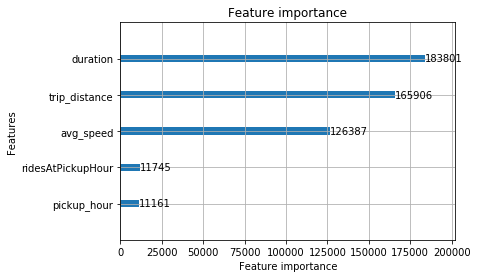

In [23]:
lgb.plot_importance(code1_model, max_num_features=10)

## Prediction

In [24]:
code1prediction = np.round(code1_model.predict(code1test[features])*2)/2

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
code1prediction

In [ ]:
code1test = code1test.assign(fare_amount_prediction = code1prediction)

# Ratecode 2 (JFK)

## Building the Model

No model building neccessary, all rides cost 52$

In [ ]:
code2data = train[train.RatecodeID == 2]
code2test = test[test.RatecodeID == 2]

## Prediction

In [ ]:
code2test["fare_amount_prediction"] = 52.0

# Ratecode 3 (Newark)

## Building the Model

In [25]:
code3data = train[train.RatecodeID == 3]

In [26]:
code3test = test[test.RatecodeID == 3]

In [27]:
%%time
features = ["duration","trip_distance","avg_speed","ridesAtPickupHour","pickup_hour"]
code3_model = optimisedLGM(param_grid,code3data[features],code3data["fare_amount"]-20)

Total parameter combinations to run: 5
Starting run 1
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 7, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 6.32118 + 0.0898515
[200]	cv_agg's l1: 5.40236 + 0.0864623
[300]	cv_agg's l1: 4.70288 + 0.0851631
[400]	cv_agg's l1: 4.13374 + 0.0931556
[500]	cv_agg's l1: 3.65932 + 0.0830107
[600]	cv_agg's l1: 3.26608 + 0.0768116
[700]	cv_agg's l1: 2.94976 + 0.0755124
[800]	cv_agg's l1: 2.68184 + 0.0713168
[900]	cv_agg's l1: 2.44556 + 0.0654861
[1000]	cv_agg's l1: 2.24491 + 0.0598136
[1100]	cv_agg's l1: 2.03455 + 0.0574693
[1200]	cv_agg's l1: 1.76629 + 0.0478241
[1300]	cv_agg's l1: 1.53938 + 0.0341861
[1400]	cv_agg's l1: 1.36948 + 0.0256537
[1500]	cv_agg's l1: 1.23755 + 0.0152891
[1600]	cv_agg's l1: 1.14492 + 0.0124463
[1700]	cv_agg's l1: 1.07562 + 0.0117453
[1800]	cv_agg's l1: 1.02571 + 0.011244
[1900]	cv_agg's l1: 0.988005 + 0.0113142
[2000]	cv_agg's l1: 0.960461 +

[8900]	cv_agg's l1: 0.78027 + 0.0064382
[9000]	cv_agg's l1: 0.780241 + 0.00643898
[9100]	cv_agg's l1: 0.780179 + 0.00645239
[9200]	cv_agg's l1: 0.780117 + 0.00646624
[9300]	cv_agg's l1: 0.780069 + 0.00648258
[9400]	cv_agg's l1: 0.78003 + 0.00650132
[9500]	cv_agg's l1: 0.779977 + 0.00649629
[9600]	cv_agg's l1: 0.779907 + 0.00652489
[9700]	cv_agg's l1: 0.779879 + 0.00655474
[9800]	cv_agg's l1: 0.779817 + 0.00651437
Run done, took: 24.07 s
Starting run 3
{'bagging_fraction': 0.8, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'learning_rate': 0.003, 'num_leaves': 150, 'num_threads': 4, 'objective': 'mae', 'verbose': -1}
[100]	cv_agg's l1: 5.98777 + 0.0801301
[200]	cv_agg's l1: 4.81673 + 0.0853936
[300]	cv_agg's l1: 3.9269 + 0.0822157
[400]	cv_agg's l1: 3.24834 + 0.0786918
[500]	cv_agg's l1: 2.72237 + 0.0742806
[600]	cv_agg's l1: 2.31075 + 0.0651006
[700]	cv_agg's l1: 1.98672 + 0.0549708
[800]	cv_agg's l1: 1.71895 + 0.0415745
[900]	cv_agg's l1: 1.46382 + 0.0301264
[1000]	cv_agg's l1: 1.26991

## Prediction

In [28]:
code3prediction = np.round(code3_model.predict(code3test[features])*2)/2+20
code3test = code3test.assign(fare_amount_prediction = code3prediction)

ValueError: train and valid dataset categorical_feature do not match.

# Ratecode 4 (Nassau or Westchester)

## Building the Model

In [ ]:
code4data = train[train.RatecodeID == 4]
code4test = test[test.RatecodeID == 4]
np.shape(code4test)

In [ ]:
#shapely can be installed via anaconda -> environments
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
# returns whether the point given is in the area given
def inArea(polygon,lat,long):
    point = Point(lat,long);
    poly = Polygon(polygon)
    return poly.contains(point)    

In [ ]:
#cords for a polygon around manhatten, manually set via google maps
manhattan_cords = [(40.882207, -73.933869), #1
         (40.872343, -73.908292), #2
         (40.836117, -73.933011), #3
         (40.804680, -73.931123), #4
         (40.798833, -73.918591), #5
         (40.739289, -73.967000), #6
         (40.707155, -73.973866), #7
         (40.699217, -74.021416), #8
         (40.759316, -74.012662)] #9

In [ ]:
#apply to train set
code4data["endsInManhattan"] = code4data.apply(lambda x : inArea(manhattan_cords,x["dropoff_latitude"],x["dropoff_longitude"]),axis=1)
code4data["startsInManhattan"] = code4data.apply(lambda x : inArea(manhattan_cords,x["pickup_latitude"],x["pickup_longitude"]),axis=1)

In [ ]:
from geopy.distance import geodesic
from geopy.distance import great_circle

In [ ]:
#calculate air line distance for train data set
code4data["airlineDistance"] = code4data.apply(lambda x: geodesic((x["pickup_latitude"],x["pickup_longitude"]),
                                                                  (x["dropoff_latitude"],x["dropoff_longitude"])).miles,axis=1)

In [ ]:
code4data.airlineDistance.describe()

In [ ]:
np.shape(code4data[["airlineDistance","trip_distance"]])

In [ ]:
np.shape(code4data[code4data.trip_distance<code4data.airlineDistance])

In [ ]:
code4data = code4data[code4data.trip_distance >= code4data.airlineDistance]

In [ ]:
ax = sns.regplot(code4data.trip_distance,code4data.airlineDistance)
ax.plot([0,0],[40,40], linewidth=2,color="red")

In [ ]:
# all bridges and tunnels to/from manhattan, bridges marked with ! are highways or tunnels and more likely to be used by taxis
bridges = [ (40.877720, -73.922362), # 0 henry hudson bridge !
          (40.873648, -73.911075), # 1 broadway !
          (40.862840, -73.914986), # 2 university heights bridge
          (40.846674, -73.927806), # 3 washington bridge - close to v
          (40.845522, -73.928256), # 4 alexander hamilton bridge !
          (40.828062, -73.933873), # 5 macombs dam bridge
          (40.819489, -73.933058), # 6 145th st bridge - close to v
          (40.814081, -73.933187), # 7 madison avenue bridge
          (40.807591, -73.932399), # 8 third avenue bridge
           (40.803516, -73.928818),# 9 willis ave bridge
           (40.800368, -73.927835), # 10 robert f kennedy bridge !
           (40.756681, -73.954185), # 11 ed koch queensboro bridge !
           (40.745106, -73.964063), # 12 queens midtown tunnel !
           (40.713407, -73.972299), # 13 williamsburg bridge
           (40.707095, -73.990500), # 14 manhattan bridge
           (40.705972, -73.996851), # 15 brooklyn bridge !
           (40.701161, -74.015692), # 16 Hugh l Carey Tunnel
           (40.727487, -74.020880), # 17 holland tunnel
           (40.763370, -74.010028), # 18 lincoln tunnel !
           (40.851644, -73.952118), # 19 george washington bridge !
          ]

In [ ]:
# try to find out which bridge is used in a trip 
# assumption: the bridge is used that minimizes the pickup-bridge-dropoff distance (air-line distance)
counter = 1
for index, row in code4data.iterrows():
    # 4 options:
    # starts in city, ends in city --> should not have ratecode 4 -> outlier, ignore
    # starts in city, ends out of city -> standard trip
    # starts out of city, ends out of city -> no calculations to be done here, use double rate for whole trip
    # starts out of city, ends in city -> reverse standard trip
    startP = (row["pickup_latitude"],row["pickup_longitude"])
    endP = (row["dropoff_latitude"],row["dropoff_longitude"])
    
    if(row.startsInManhattan and row.endsInManhattan):
        #print("Outlier found, index",index)
        continue
    elif (not row.startsInManhattan and not row.endsInManhattan):
        #print("Complete out of city trip, index",index)
        code4data.at[index,"Bridge"] = None;
        code4data.at[index,"in_city_distance"] = 0;
        code4data.at[index,"out_of_city_distance"] = geodesic(startP, endP).miles
        code4data.at[index,"total_over_bridge_distance"] = geodesic(startP, endP).miles  
        continue
    elif (not row.startsInManhattan and  row.endsInManhattan): # reverse trip
        temp = startP # here we swap start and endpoints so its similar to a standard trip
        startP = endP
        endP = temp
    
    #find closest bridge
    closest_bridge_index = -1
    closest_total_bridge_distance = float('inf')
    for i in range(len(bridges)):
        distance_to_bridge = geodesic(startP, bridges[i]).miles
        distance_to_dest =  geodesic(bridges[i],endP).miles
        total = distance_to_bridge + distance_to_dest
        if(total < closest_total_bridge_distance):
            closest_total_bridge_distance = total
            closest_bridge_index = i
            closest_distance_to_bridge = distance_to_bridge
            closest_distance_to_dest = distance_to_dest
            
    #print("Route {} travels over bridge/tunnel {} (to bridge: {:0.2f}, to dest: {:0.2f}, total: {:0.2f}, trip_distance : {:0.2f})".format(
    #    counter, closest_bridge_index,closest_distance_to_bridge,closest_distance_to_dest,closest_total_bridge_distance,totalDistance))
    counter = counter + 1
    
    code4data.at[index,"Bridge"] = closest_bridge_index;
    code4data.at[index,"in_city_distance"] = closest_distance_to_bridge;
    code4data.at[index,"out_of_city_distance"] = closest_distance_to_dest
    code4data.at[index,"total_over_bridge_distance"] = closest_total_bridge_distance       

In [ ]:
#states how much of the fare was contributed by ride in the city. Calculated by 
code4data["inCityPercentage"] = code4data.apply(lambda x: x.in_city_distance/(x.in_city_distance+2*x.out_of_city_distance+0.0001),axis=1)

In [ ]:
#2.5 were subtracted from fare amount (inital charge)
code4data["inCityFare"] = code4data.apply(lambda x: x.inCityPercentage*(x.fare_amount-2.5),axis=1)
code4data["outCityFare"] = code4data.apply(lambda x: (1-x.inCityPercentage)*(x.fare_amount-2.5),axis=1)

In [ ]:
code4data["inCityTripDistanceExtreme"] = code4data.apply(lambda x: x.inCityPercentage*x.trip_distance,axis=1)
code4data["outCityTripDistanceExtreme"] = code4data.apply(lambda x: (1-x.inCityPercentage)*x.trip_distance,axis=1)

In [ ]:
code4data["inCityTripDistance"] = code4data.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)
code4data["outCityTripDistance"] = code4data.apply(lambda x: x.out_of_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

In [ ]:
code4data["in_city_ratio"] = code4data.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

Now we have to train three models. Two for trips that start in the city and end out of it and vice versa, thus using both the standard and the doubled rate (one model for each). The predctions are then add up. The third model is for trips that are completly out of the city and therefore only use the doubled rate. Here more information can be used from the dataset, because we do not have to make assumptions on where the trip was split.

In [ ]:
code4data_mixed = code4data[code4data.startsInManhattan ^ code4data.endsInManhattan] # trips that used a bridge -> entered/left manhattan
np.shape(code4data_mixed)

In [ ]:
code4data_out = code4data[(code4data.startsInManhattan==False) & (code4data.endsInManhattan==False)] # trips that not used a bridge -> never were in Manhattan
np.shape(code4data_out)

In [ ]:
%%time
#chose features
features_inner = ["inCityTripDistance","trip_distance","duration","ridesAtPickupHour","avg_speed","in_city_ratio"]
features_outer = ["outCityTripDistance","trip_distance","duration","ridesAtPickupHour","avg_speed","in_city_ratio"]

mixed_inner_train = code4data_mixed[features_inner]
mixed_outer_train = code4data_mixed[features_outer]

code4_model_inner = optimisedLGM(param_grid,mixed_inner_train,code4data_mixed["inCityFare"])

In [ ]:
%%time
code4_model_outer = optimisedLGM(param_grid,mixed_outer_train,code4data_mixed["outCityFare"])

In [ ]:
%%time
features_combined = ["inCityTripDistance","outCityTripDistance","in_city_ratio","duration","trip_distance","ridesAtPickupHour","avg_speed"]
code4_model_combined = optimisedLGM(param_grid,code4data_mixed[features_combined],code4data_mixed["fare_amount"]-2.5)

In [ ]:
lgb.plot_importance(code4_model_combined, max_num_features=10)

In [ ]:
features_all = ["trip_distance","duration","avg_speed","ridesAtPickupHour"]
code4_model_all = optimisedLGM(param_grid,code4data[features_all],code4data["fare_amount"]-2.5)

In [ ]:
lgb.plot_importance(code4_model_all, max_num_features=10)

Next: model for outer trips.


In [ ]:
%%time
# make train set
features = ["trip_distance","duration","ridesAtPickupHour","avg_speed"]

code4_model_out = optimisedLGM(param_grid,code4data_out[features],code4data_out["fare_amount"]-2.5)

In [ ]:
lgb.plot_importance(code4_model_out, max_num_features=10)

## Prediction

In [ ]:
#apply to test set
code4test["endsInManhattan"] = code4test.apply(lambda x : inArea(manhattan_cords,x["dropoff_latitude"],x["dropoff_longitude"]),axis=1)
code4test["startsInManhattan"] = code4test.apply(lambda x : inArea(manhattan_cords,x["pickup_latitude"],x["pickup_longitude"]),axis=1)

We have four possible trip patterns:
    1. starts in city, ends in city --> should not have ratecode 4 -> outlier, ignore
    2. starts in city, ends out of city -> standard trip
    3. starts out of city, ends out of city -> no calculations to be done here, use double rate for whole trip
    4. starts out of city, ends in city -> reverse standard trip

In [ ]:
np.shape(code4test)

In [ ]:
#option1: trips that start and end in manhattan, these should not have this ratecode
code4test_wrong = code4test[(code4test.startsInManhattan & code4test.endsInManhattan)]
np.shape(code4test_wrong)

In [ ]:
#option2 & option 4: 
code4test_mixed = code4test[code4test.startsInManhattan ^ code4test.endsInManhattan] 
np.shape(code4test_mixed)

In [ ]:
#option 3:
code4test_out = code4test[(code4test.startsInManhattan==False) & (code4test.endsInManhattan==False)] 
np.shape(code4test_out)

In [ ]:
# try to find out which bridge is used in a trip 
# assumption: the bridge is used that minimizes the pickup-bridge-dropoff distance (air-line distance)
counter = 1
for index, row in code4test_mixed.iterrows():
    
    startP = (row["pickup_latitude"],row["pickup_longitude"])
    endP = (row["dropoff_latitude"],row["dropoff_longitude"])
    
    if(row.startsInManhattan and row.endsInManhattan):
        #print("Outlier found, index",index)
        continue
    elif (not row.startsInManhattan and not row.endsInManhattan):
        #print("Complete out of city trip, index",index)
        code4test_mixed.at[index,"bridge"] = None;
        code4test_mixed.at[index,"in_city_distance"] = 0;
        code4test_mixed.at[index,"out_of_city_distance"] = geodesic(startP, endP).miles
        code4test_mixed.at[index,"total_over_bridge_distance"] = geodesic(startP, endP).miles  
        continue
    elif (not row.startsInManhattan and  row.endsInManhattan): # reverse trip
        temp = startP # here we swap start and endpoints so its similar to a standard trip
        startP = endP
        endP = temp
    
    #find closest bridge
    closest_bridge_index = -1
    closest_total_bridge_distance = float('inf')
    for i in range(len(bridges)):
        distance_to_bridge = geodesic(startP, bridges[i]).miles
        distance_to_dest =  geodesic(bridges[i],endP).miles
        total = distance_to_bridge + distance_to_dest
        if(total < closest_total_bridge_distance):
            closest_total_bridge_distance = total
            closest_bridge_index = i
            closest_distance_to_bridge = distance_to_bridge
            closest_distance_to_dest = distance_to_dest
            
    #print("Route {} travels over bridge/tunnel {} (to bridge: {:0.2f}, to dest: {:0.2f}, total: {:0.2f}, trip_distance : {:0.2f})".format(
    #    counter, closest_bridge_index,closest_distance_to_bridge,closest_distance_to_dest,closest_total_bridge_distance,totalDistance))
    counter = counter + 1
    
    code4test_mixed.at[index,"bridge"] = closest_bridge_index;
    code4test_mixed.at[index,"in_city_distance"] = closest_distance_to_bridge;
    code4test_mixed.at[index,"out_of_city_distance"] = closest_distance_to_dest
    code4test_mixed.at[index,"total_over_bridge_distance"] = closest_total_bridge_distance       

In [ ]:
#states how much of the fare was contributed by ride in the city. Calculated by 
code4test_mixed["inCityPercentage"] = code4test_mixed.apply(lambda x: x.in_city_distance/(x.in_city_distance+2*x.out_of_city_distance+0.0001),axis=1)

In [ ]:
code4test_mixed["inCityTripDistance"] = code4test_mixed.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)
code4test_mixed["outCityTripDistance"] = code4test_mixed.apply(lambda x: x.out_of_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

In [ ]:
code4test_mixed["inCityTripDistanceExtreme"] = code4test_mixed.apply(lambda x: x.inCityPercentage*x.trip_distance,axis=1)
code4test_mixed["outCityTripDistanceExtreme"] = code4test_mixed.apply(lambda x: (1-x.inCityPercentage)*x.trip_distance,axis=1)

In [ ]:
code4test_mixed["in_city_ratio"] = code4test_mixed.apply(lambda x: x.in_city_distance/(x.in_city_distance+x.out_of_city_distance),axis=1)

In [ ]:
# prediction for the inner city part
code4_mixed_inner_pred = code4_model_inner.predict(code4test_mixed[features_inner])

In [ ]:
#prediction for out of city part
code4_mixed_outer_pred = code4_model_outer.predict(code4test_mixed[features_outer])

In [ ]:
code4_mixed_combined_pred = code4_model_combined.predict(code4test_mixed[features_combined])

In [ ]:
#combine the results
#round comined predictions to closest .5
#add 2.5 inital charge which was removed before training
code4test_mixed["fare_amount_prediction"]=np.round((code4_mixed_inner_pred+code4_mixed_outer_pred)*2)/2+2.5

In [ ]:
code4test_mixed["fare_amount_prediction"].describe()

In [ ]:
code4test_mixed["fare_amount_prediction"]=np.round(code4_mixed_combined_pred*2)/2+2.5

In [ ]:
code4test_mixed["fare_amount_prediction"].describe()

Next: predict out trips.

In [ ]:
code4test_out_pred = code4_model_out.predict(code4test_out[features])
code4test_out["fare_amount_prediction"]=np.round(code4test_out_pred*2)/2+2.5

Lastly: predict trips that only were in Manhattan with double rate model (same as outer trips)

In [ ]:
code4_test_wrong_pred = code4_model_out.predict(code4test_wrong[features])
code4test_wrong["fare_amount_prediction"]=np.round(code4_test_wrong_pred*2)/2+2.5

In [ ]:
#combine all code 4 dataframes with predictions
code4test = pd.concat([code4test_mixed,code4test_out,code4test_wrong])

# Ratecode 5 (Negotiated Fares)

## Building the Model

In [ ]:
code5data = train[train.RatecodeID == 5]
code5data = code5data.assign(fare_to_distance_ratio = code5data.fare_amount/code5data.trip_distance)
code5data = code5data[(code5data.fare_to_distance_ratio<20) & (code5data.fare_to_distance_ratio>=1)]
code5test = test[test.RatecodeID == 5]


In [ ]:
code5data.tolls_amount.describe()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(code5data.day)

In [ ]:
list(le.classes_)

In [ ]:
code5data["day_int"] = le.transform(code5data.day)

In [ ]:
code5data["weekend"] = code5data.apply(lambda x: ((x.day == "Sunday") | (x.day=="Saturday")) and 1 or 0,axis=1)

In [ ]:
%%time
features = ["duration","trip_distance","avg_speed","ridesAtPickupHour","pickup_hour","tolls_amount"]

code5_model = optimisedLGM(param_grid,code5data[features],code5data["fare_amount"]-2.5)

In [ ]:
lgb.plot_importance(code5_model, max_num_features=10)

In [ ]:
ax = sns.distplot(code5data.fare_amount,kde=False,bins=20);

In [ ]:
code5data.fare_amount.value_counts()

In [ ]:
code5data.shape

In [ ]:
t = code5data[code5data.fare_amount%0.5 != 0][["trip_distance","duration","fare_amount"]]

In [ ]:
t["fare_to_distance_ratio"]= t.fare_amount/t.trip_distance

In [ ]:
t.fare_to_distance_ratio.describe()

In [ ]:
ax = sns.distplot(t.fare_to_distance_ratio,kde=False,bins=20);

In [ ]:
ax = sns.distplot(code5data.fare_to_distance_ratio,kde=False,bins=20);

## Prediction

In [ ]:
code5prediction = code5_model.predict(code5test[features])
code5test = code5test.assign(fare_amount_prediction = code5prediction)

# Recombine all predictions and save

In [ ]:
testResult = pd.concat([code1test,code2test,code3test,code4test,code5test])

In [ ]:
testResult.to_csv("C:\\Users\\Leo\\Dropbox\\Info Göttingen\\Practical Course Data Science\\Task 2\\data\\test_prediction.csv")

In [ ]:
testResult.fare_amount_prediction.describe()

In [ ]:
testResult.describe()

In [ ]:
testResult[testResult.fare_amount_prediction == testResult.fare_amount_prediction.max()]

In [ ]:
testResult[testResult.trip_distance == testResult.trip_distance.max()]

In [ ]:
testResult.RatecodeID.value_counts()

# Archive

### Ratecode 1

### Ratecode 4